# Imports

In [1]:
!pip install fermat
import fermat as F
import numpy as np
import scipy.sparse as sp
from scipy.spatial import  distance_matrix
from sklearn.manifold import TSNE
from scipy.optimize import minimize
from sklearn.neighbors import KDTree
from scipy.optimize import LinearConstraint
from scipy.sparse import csr_matrix


from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Fermat Optimal Transport definitions

'data' is always given as np matrix where each row is a point in R**(columns)

fermat distance between two points (x,y) outside the manifold: choose the closest neighbour x' of the starting point  x and cost will be cost(x',y)+euclid_dist(x,x')**alpha


 gradient on y of fermat_dist(x,y) with x,y outside the manifold:  the k-nn of y with smallest fermat_cost(x',y)

In [ ]:
#Builds fermat graph given data, alpha, method (and if 'D' is chosen with k_fermat neighbours)
#RETURNS: fermat distance matrix between points of data and a KD-Tree 


def fermat_graph(data,alpha,method='FW',k_fermat=30):
    model=F.Fermat(alpha, path_method=method,k=k_fermat)
    model.fit(np.matrix(distance_matrix(data,data)))
    fermat_distances = model.get_distances()
    tree = KDTree(data, leaf_size=2)
    return fermat_distances,tree
              

#Computes fermat_cost of transporting initialData to x with the given fermat_distances
#initial data will be points

#It uses the KD-Tree built with fermat_graph() as well as a parameter 'k' which is 
#the amount of neighbours to look at when getting the fermat distance for a point that
#is not in the graph (including it may be computationally expensive)
#It also recieves the original data and the alpha used to build fermat_distances
              
#RETURNS: fermat cost and gradient of that cost
def fermat_cost(x,initialData,dimension,fermat_distances,tree,data,k,alpha):
    assert(len(x)==(initialData.shape[0])*dimension)
    real_x=x.reshape(-1,dimension)     
    res=0
    gradient=np.zeros(x.shape)
    for i in range(initialData.shape[0]):
        dist,grad_idx=fermat_dist(initialData[i,:],real_x[i,:],fermat_distances,tree,k,alpha) 
        q=data[grad_idx,:] 
        local_grad=alpha*(np.linalg.norm(q-real_x[i,:])**(alpha-2))*(real_x[i,:]-q)
        
        res+=dist                      
        gradient[dimension*i:dimension*(i+1)]=local_grad
    return res,gradient


#Computes fermat distance between start  and end using fermat_distances
              
#it also recieves the KD-tree, numbre of neighbours to look at, and alpha used in fermat
              
#RETURNS: fermat distance between start and end, as well as the index of the k-nearest neighbour
#of end with smallest fermat distance to start
def fermat_dist(start,end,fermat_distances,tree,k,alpha):
    
    start_euclid_dist,start_ind=tree.query([start],k=1)
    idx=start_ind[0,0]
    start_euclid_dist=np.power(start_euclid_dist,alpha)
    
    end_euclid_dist,end_ind=tree.query([end],k=k)
    end_euclid_dist=np.power(end_euclid_dist,alpha)
        
    dist=min([ fermat_distances[idx,end_ind[0,i]]+end_euclid_dist[0,i] for i in range(end_euclid_dist.shape[1])])
    
    minim=np.argmin([ fermat_distances[idx,end_ind[0,i]] for i in range(end_ind.shape[1])]) 
    grad_idx=end_ind[0,minim] #index of k-nearest neighbour with smallest fermat_distance to idx.
    
    return dist+start_euclid_dist[0,0],grad_idx
              

#Here initialData are the points, and x the trasnportation of those
##UNUSED
def euclidean_cost(x,initialData):
    assert(len(initialData.flatten())==len(x))
    dimension=initialData.shape[1]
    real_x=x.reshape(-1,dimension)
    res=0
    gradient=np.zeros(x.shape)
    for i in range(initialData.shape[0]):
        res+=np.linalg.norm(initialData[i,:]-real_x[i,:])
        local_gradient=2*(real_x[i,:]-initialData[i,:])
        gradient[dimension*i:(i+1)*dimension]=local_gradient
    return res,gradient


A small example using these costs

In [ ]:
data=np.random.random((10,2))

x=np.ones(16)

##Euclidean
print(euclidean_cost(x,data[0:8,:]))

##Fermat

initialData=data[0:8,:]
dimension=2
alpha=2
k=2
f_dist,tree=fermat_graph(data,alpha=alpha)


fermat_cost(x,initialData,dimension,f_dist,tree,data,k,alpha)

(6.456505159680942, array([0.29226105, 0.07820767, 0.05405854, 1.37733427, 1.71033357,
       1.47424558, 0.67197629, 1.13003025, 1.63684106, 0.85809073,
       1.60862659, 0.37836636, 1.75762094, 1.21223729, 0.59927153,
       1.9327753 ]))


(3.024599442816137,
 array([0.29226105, 0.07820767, 0.41950372, 1.19813727, 0.41950372,
        1.19813727, 0.41950372, 1.19813727, 0.41950372, 1.19813727,
        0.41950372, 1.19813727, 0.41950372, 1.19813727, 0.41950372,
        1.19813727]))

In [ ]:
##Minimize the transported of initialData (indexes of points from data) given the fermat_distances
#it recieves other parameters explained before as well as constraints, xinit and maxiter and method
#for the constrained-minimization
def fermat_opt_transport(initialData,dimension,fermat_distances,tree,data,k,alpha,cons,xinit,maxiter=100,method='trust-constr',callback=True):
    
    opt={"disp": False, "maxiter":maxiter}
    
    f= lambda x: fermat_cost(x,initialData,dimension,fermat_distances,tree,data,k,alpha)
    
    global Nfeval
    Nfeval=1
    if callback:
        def callbackF(Xi,status):
            global Nfeval
            print ('Iter:'+ str(Nfeval)+', cost: '+str(f(Xi)[0])+',  max constr-viol:'+ str(np.max([abs(con['fun'](Xi)) for con in cons])))
            Nfeval += 1
    else:
        callbackF=None
    
    res = minimize(f, x0=xinit.flatten(), jac=True,constraints=cons,options=opt, method=method,callback=callbackF)
    return res

    
def constraints(initialPoints,finalData,first_moment=True, second_moment=True, kernel_centers=None, kernel_h=None):
    dimension=finalData.shape[1]
    finalPoints=finalData.shape[0]
    Y=finalData.flatten()
    cons=[]
    
    
    if first_moment:
        global aux
        aux=[]
        global b
        b=np.mean(finalData,axis=0)
        for i in range(dimension):
            to_repeat=np.array([1 if j==i else 0 for j in range(dimension)])
            aux.append(np.tile(to_repeat,initialPoints)/initialPoints)
            cons.append({'type': 'eq', 'fun': lambda x,i=i: aux[i]@x.T - b[i] ,'jac': lambda x,i=i: aux[i]})
            #HAY QUE PONER LAMBDA CON DOS PARAMETROS PARA QUE FIJE EL i Y NO LO CAMBIE
    
    select_restrictions=np.zeros((dimension,dimension))
    id_initialPoints=sp.eye(initialPoints)
    id_finalPoints=sp.eye(finalPoints)
    if second_moment:
        global A,B
        A=[]
        B=[]
        ij=0
        for i in range(dimension):
            for j in range(i,dimension):
                select_restrictions[j,i]=1
                A.append(sp.kron(id_initialPoints,select_restrictions)/initialPoints)               
                B.append(sp.kron(id_finalPoints,select_restrictions)/finalPoints)
                cons.append({'type': 'eq', 'fun': lambda x,ij=ij: (x@A[ij]@x.T)-(Y@B[ij]@Y.T),'jac': lambda x,ij=ij: 2*A[ij]@x.T})
                #HAY QUE PONER LAMBDA CON DOS PARAMETROS PARA QUE FIJE EL i Y NO LO CAMBIE
                select_restrictions[j,i]=0
                ij+=1
                
    ##TODO: IMPLEMENTAR LOS KERNEL
    
    return cons


# Making easier to call it: fermat_ot wraps all the definitions, requiring only the problem of optimal transport input

### data: points defining fermat_graph
### initialData: [start,end), the points that will be transported are data[start:end,:]
### finalData: destination points (distribution)
### alpha: parameter used defining fermat_graph
### k: number of neighbours used to calculate gradient and fermat distance of points outside data
### xinit: initial value of the transported points


In [ ]:
def fermat_ot(data,initialData,finalData,alpha,k,xinit,maxiter=100,first_moment=True,second_moment=True):
    initialPoints=initialData.shape[0]
    dimension=data.shape[1]
    f_dist,tree=fermat_graph(data,alpha)
    cons=constraints(initialPoints,finalData,first_moment,second_moment)
    res=fermat_opt_transport(initialData,dimension,f_dist,tree,data,k,alpha,cons,xinit,maxiter)
    return res

# Example using fermat optimal transport

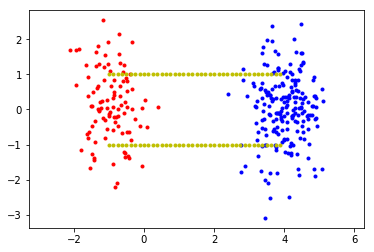

In [ ]:
puntos=200
#Z son los iniciales
#Y son los objetivo
#x son los Z transformados, lo que voy a optimizar

#OJO GUARDO LA DATA COMO XY XY XY XY (no como XXXX YYYYY ) 

y1, y2 = np.random.multivariate_normal([4,0], [[0.3,0],[0,1]], puntos).T
y1=np.array(y1)
y2=np.array(y2)
y1=y1.reshape(-1,1)
y2=y2.reshape(-1,1)

Ycol=np.concatenate((y1,y2),axis=1)
Y=Ycol.flatten()


x1, x2 = np.random.multivariate_normal([-1,0], [[0.3,0],[0,1]], puntos//2).T
x1=np.array(x1)
x2=np.array(x2)
x1=x1.reshape(-1,1)
x2=x2.reshape(-1,1)
Zcol=np.concatenate((x1,x2),axis=1)
Z=Zcol.flatten()


top=np.ones((40,2))
bottom=-np.ones((40,2))
dx=5/top.shape[0]
for i in range(top.shape[0]):
    top[i,0]=i*dx-1
    bottom[i,0]=i*dx-1

plt.axis('equal')
plt.plot(x1,x2,'.',c='r')
plt.plot(y1,y2,'.',c='b')
plt.plot(top[:,0],top[:,1],'.',c='y')
plt.plot(bottom[:,0],bottom[:,1],'.',c='y')


In [ ]:
data=np.concatenate((Zcol,Ycol,bottom,top),axis=0)

alpha=2
k=10
finalData=Ycol
initialData=Zcol-[2,0]

xinit=np.random.random(Zcol.shape)

#FILTRO WARNINGS!!
import warnings
warnings.filterwarnings('ignore')

res=fermat_ot(data,initialData,finalData,alpha,k,xinit,maxiter=100)



Iter:1, cost: 227.85955075819334,  max constr-viol:15.99412134989128
Iter:2, cost: 229.29370391317846,  max constr-viol:15.896644817184443
Iter:3, cost: 232.50344402760751,  max constr-viol:14.83193549157551
Iter:4, cost: 463.34482695956956,  max constr-viol:9.11360890528859
Iter:5, cost: 290.53098921827205,  max constr-viol:1.3370289737817558
Iter:6, cost: 266.15677751983844,  max constr-viol:0.28442245579636705
Iter:7, cost: 261.9972874671532,  max constr-viol:0.04098844985262318
Iter:8, cost: 259.6310231447391,  max constr-viol:0.027464188698324947
Iter:9, cost: 259.6310231447391,  max constr-viol:0.027464188698324947
Iter:10, cost: 259.6310231447391,  max constr-viol:0.027464188698324947
Iter:11, cost: 259.6310231447391,  max constr-viol:0.027464188698324947
Iter:12, cost: 259.6310231447391,  max constr-viol:0.027464188698324947
Iter:13, cost: 258.716663256872,  max constr-viol:0.025700986993346425
Iter:14, cost: 258.1489354271179,  max constr-viol:0.018868161715356817
Iter:15, cos

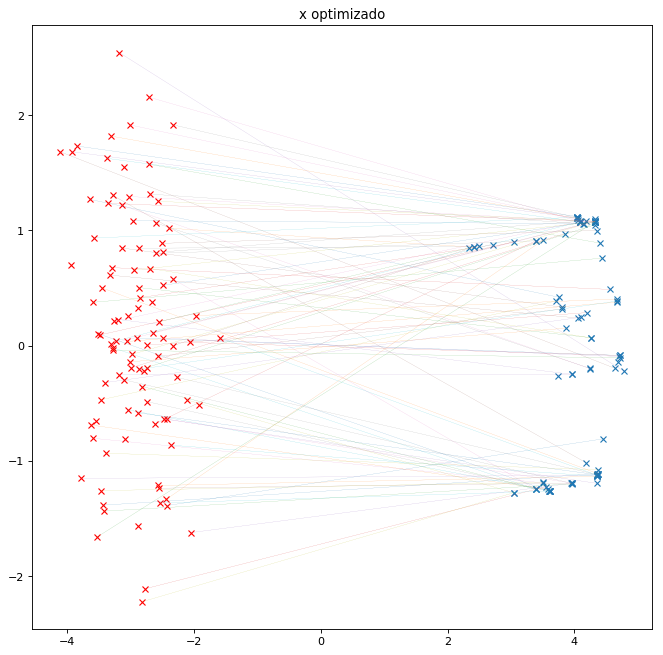

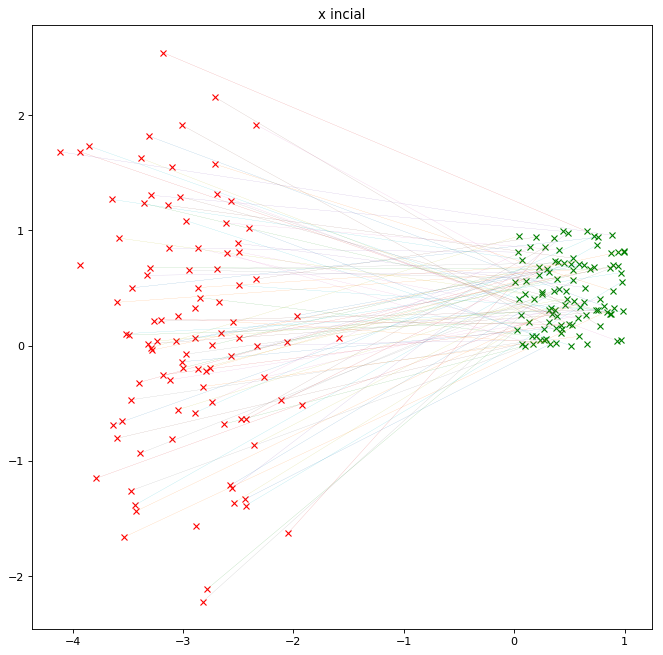

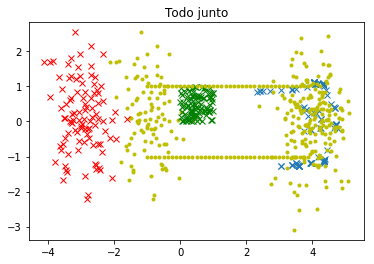

In [ ]:
dimension=2

X_transported=res['x']
X_t=X_transported.reshape(-1,dimension)

percent=0.9 #PORCENTAJE DE LINEAS QUE PLOTEO



from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
x=X_t[:,0]
y=X_t[:,1]

plt.plot(x,y,'x')
plt.plot(initialData[:,0],initialData[:,1],'x',c='r')

#plt.plot(y1,y2,'.',c='g')
for i in range(int(len(x)*percent)):
    plt.plot([initialData[i,0],x[i]],[initialData[i,1],y[i]],lw=0.1)
plt.title('x optimizado')
plt.show()
#plt.plot([2,1],[4,4])



figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
inicial=xinit

plt.plot(initialData[:,0],initialData[:,1],'x',c='r')
plt.plot(inicial[:,0],inicial[:,1],'x',c='g')

for i in range(int(len(x)*percent)):
    plt.plot([initialData[i,0],inicial[i,0]],[initialData[i,1],inicial[i,1]],lw=0.1)

plt.title('x incial')
plt.show()



plt.plot(x,y,'x')
plt.plot(x1,x2,'.',c='y')
plt.plot(y1,y2,'.',c='y')
plt.plot(inicial[:,0],inicial[:,1],'x',c='g')
plt.plot(initialData[:,0],initialData[:,1],'x',c='r')

plt.plot(top[:,0],top[:,1],'.',c='y')
plt.plot(bottom[:,0],bottom[:,1],'.',c='y')
plt.title('Todo junto')
plt.show()